# 04 Baseline Model

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import boto3
import sagemaker
from pyathena import connect
import matplotlib.pyplot as plt


/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [ ]:

import joblib
import os

baseline_model_path = "baseline_model.pkl"

# Check if a baseline model exists
if os.path.exists(baseline_model_path):
    print("🔄 Loading existing baseline model for comparison...")
    baseline_model = joblib.load(baseline_model_path)

    # Evaluate baseline model on the test set
    y_baseline_pred = baseline_model.predict(X_test)
    baseline_accuracy = accuracy_score(y_test, y_baseline_pred)

    print(f"📊 Baseline Model Accuracy: {baseline_accuracy:.4f}")
else:
    print("⚠️ No baseline model found. This will be the first model.")
    baseline_accuracy = 0.0  # Set a low baseline if no previous model exists


In [ ]:

import boto3
import joblib
import os
import pandas as pd

# Define S3 paths for best model and metrics
s3_client = boto3.client("s3")
bucket_name = "<your-s3-bucket>"  # Replace with your actual bucket
model_key = "best_model.pkl"
metrics_key = "best_model_metrics.csv"

# Local paths
best_model_path = "best_model.pkl"
best_metrics_path = "best_model_metrics.csv"

print("📦 Storing the initial best model and metrics in S3...")

# Save model locally
joblib.dump(model, best_model_path)

# Save initial metrics
initial_metrics = pd.DataFrame({"accuracy": [test_accuracy]})
initial_metrics.to_csv(best_metrics_path, index=False)

# Upload to S3
s3_client.upload_file(best_model_path, bucket_name, model_key)
s3_client.upload_file(best_metrics_path, bucket_name, metrics_key)

print("✅ Initial model and metrics successfully stored in S3.")


In [ ]:

import joblib

# Load the saved baseline model
baseline_model_path = "baseline_model.pkl"
baseline_model = joblib.load(baseline_model_path)

# Evaluate baseline model on the test set
y_baseline_pred = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_baseline_pred)

print(f"📊 Baseline Model Accuracy: {baseline_accuracy:.4f}")


In [2]:
%store

Stored variables and their in-db values:
account_id                               -> '607916531205'
create_base_csv_athena_db                -> True
create_base_csv_athena_table             -> True
database_name                            -> 'db_airline_delay_cause'
dev_feature_group_name                   -> 'airline_delay_features_dev'
dev_feature_store_table                  -> 'airline_delay_features_dev_1739939876'
dev_s3_path                              -> 's3://sagemaker-us-east-1-607916531205/data/develo
dev_s3_uri                               -> 's3://sagemaker-us-east-1-607916531205/feature-sto
dev_table_name                           -> 'development_data'
packages_installed                       -> True
prod_feature_group_name                  -> 'airline_delay_features_prod'
prod_feature_store_table                 -> 'airline_delay_features_prod_1739939953'
prod_s3_path                             -> 's3://sagemaker-us-east-1-607916531205/data/produc
prod_s3_uri         

# Query Values from Development Database

In [8]:
# ✅ Retrieve stored variables
%store -r dev_feature_store_table
%store -r s3_staging_dir
%store -r region

import boto3
import pandas as pd
from pyathena import connect

# ✅ Connect to Athena using correct S3 staging directory
conn = connect(s3_staging_dir=s3_staging_dir, region_name=region)

# ✅ Retrieve all data from Feature Store using Athena
def get_feature_store_data(table_name):
    print(f"Fetching data from Feature Store Table: {table_name}")
    
    # ✅ Use the correct Athena database for feature store queries
    query = f'SELECT * FROM "sagemaker_featurestore"."{table_name}";'
    
    # ✅ Execute Athena query and load into Pandas DataFrame
    df = pd.read_sql(query, conn)

    return df

# ✅ Load data from the correct offline Feature Store table
df = get_feature_store_data(dev_feature_store_table)

# ✅ Define feature columns and target variable
features = [
    "arr_flights", "arr_del15", "carrier_ct", "weather_ct", "nas_ct", 
    "security_ct", "late_aircraft_ct", "arr_cancelled", "arr_diverted", 
    "arr_delay", "carrier_delay", "weather_delay", "nas_delay", 
    "security_delay", "late_aircraft_delay", "delay_rate"
]
target = "on_time"

# ✅ Ensure no missing values
df = df.dropna()


Fetching data from Feature Store Table: airline_delay_features_dev_1739939876


/tmp/ipykernel_151/251305686.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


# Create Linear Regression Baseline Model

In [10]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Initialize and train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)  # FIX: Add predictions for training set
y_test_pred = model.predict(X_test)    # FIX: Use correct variable name



# Evaluate Model Performance

In [11]:
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")



Mean Squared Error: 0.0123
R² Score: 0.1019


# Visualization

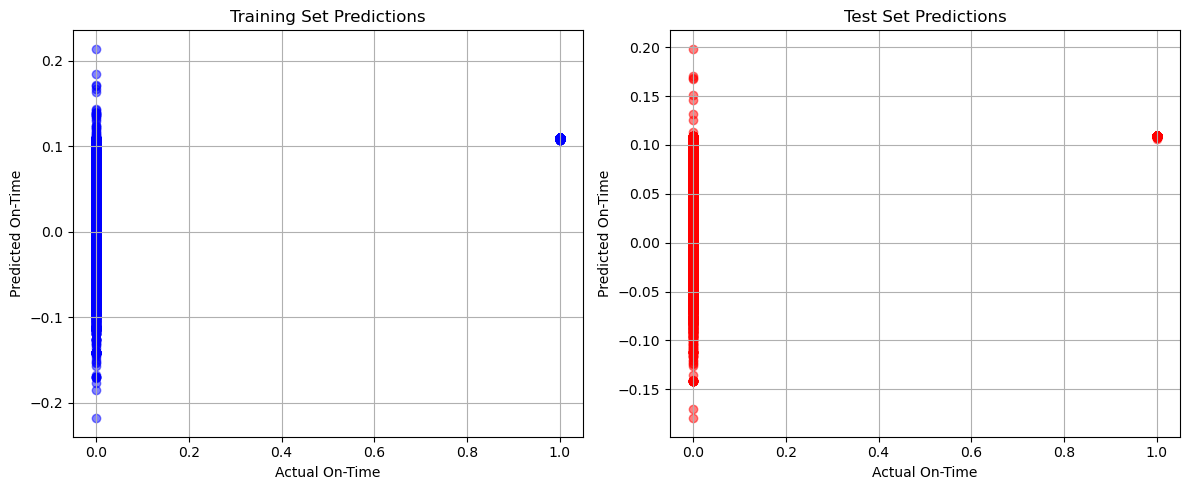

In [12]:
# Visualization
plt.figure(figsize=(12,5))

# Training Set
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5, color='blue')
plt.xlabel("Actual On-Time")
plt.ylabel("Predicted On-Time")
plt.title("Training Set Predictions")
plt.grid()

# Test Set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='red')
plt.xlabel("Actual On-Time")
plt.ylabel("Predicted On-Time")
plt.title("Test Set Predictions")
plt.grid()

plt.tight_layout()
plt.show()

# Store Model

In [13]:
# Save the model for future use
baseline_model_path = "baseline_model.pkl"
joblib.dump(model, baseline_model_path)
print(f"Model saved as {baseline_model_path}")
%store baseline_model_path

Model saved as baseline_model.pkl
Stored 'baseline_model_path' (str)


In [ ]:

import joblib
import json

# Define paths for storing model and metrics
model_store_path = "best_model.pkl"
metrics_store_path = "best_model_metrics.json"

# Save the baseline model as the first "best model"
joblib.dump(model, model_store_path)
print(f"✅ Baseline model saved as {model_store_path}")

# Store the model's initial metrics
baseline_metrics = {
    "accuracy": test_accuracy
}

with open(metrics_store_path, "w") as f:
    json.dump(baseline_metrics, f)

print(f"✅ Baseline model metrics saved as {metrics_store_path}")


# Try Logistic Regression + Scaling Instead

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions (use probabilities for better interpretation)
y_train_pred_prob = model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Convert probabilities to binary (0 or 1) based on a 0.5 threshold
y_train_pred = (y_train_pred_prob >= 0.5).astype(int)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)


✅ Training Accuracy: 0.9989
✅ Testing Accuracy: 0.9988

Confusion Matrix (Test Set):
[[25708    31]
 [    0   363]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25739
           1       0.92      1.00      0.96       363

    accuracy                           1.00     26102
   macro avg       0.96      1.00      0.98     26102
weighted avg       1.00      1.00      1.00     26102



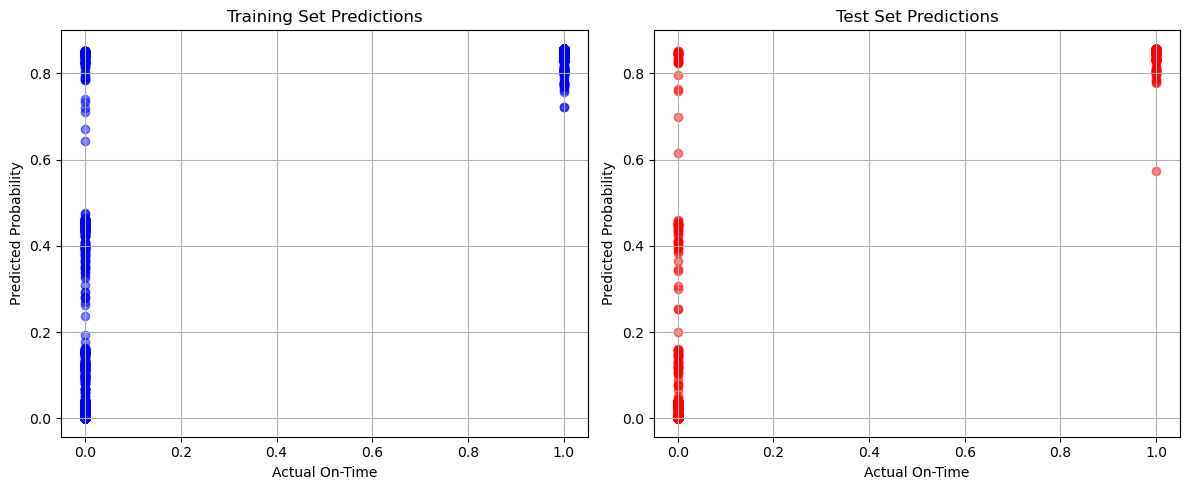

In [15]:
# Model Evaluation
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"✅ Training Accuracy: {train_accuracy:.4f}")
print(f"✅ Testing Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Visualization
plt.figure(figsize=(12,5))

# Training Set Predictions
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_prob, alpha=0.5, color='blue')
plt.xlabel("Actual On-Time")
plt.ylabel("Predicted Probability")
plt.title("Training Set Predictions")
plt.grid()

# Test Set Predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_prob, alpha=0.5, color='red')
plt.xlabel("Actual On-Time")
plt.ylabel("Predicted Probability")
plt.title("Test Set Predictions")
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate new model performance
new_model_accuracy = accuracy_score(y_test, y_test_pred)

print(f"📊 New Model Accuracy: {new_model_accuracy:.4f}")

# Define a flag file for model readiness
flag_path = "model_ready.flag"

# Compare new model to baseline
if new_model_accuracy < baseline_accuracy:
    print("🚨 New model did not outperform baseline! Failing pipeline.")
    raise ValueError("❌ New model is worse than the baseline. Stopping pipeline.")
else:
    print("✅ New model is better! Proceeding to register the model.")

    # Save a flag to signal the next step
    with open(flag_path, "w") as f:
        f.write("ready")

In [ ]:

# Define a performance threshold to keep minimum quality baseline
ACCURACY_THRESHOLD = 0.85  # Set desired minimum accuracy

# Check model performance
if test_accuracy < ACCURACY_THRESHOLD:
    print(f"🚨 Model performance below threshold: {test_accuracy:.4f} < {ACCURACY_THRESHOLD}")
    raise ValueError("❌ Model failed to meet the accuracy requirement. Stopping pipeline.")
else:
    print(f"✅ Model passed threshold with {test_accuracy:.4f} accuracy.")


In [16]:
# Save the model for future use
baseline_model_logistic_path = "baseline_model_logistic.pkl"
joblib.dump(model, baseline_model_logistic_path)
print(f"Model saved as {baseline_model_logistic_path}")
%store baseline_model_logistic_path

Model saved as baseline_model_logistic.pkl
Stored 'baseline_model_logistic_path' (str)
